In [1]:
# from model.ACA import ACA_TSP
from model.GPGACA import GradientPolicyGradient3ACA as ACA_TSP

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import animation
import progressbar
from tqdm import tqdm

In [3]:
def plot_heatmap(data, frames=100):
    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            data[i, j] = (data[i, j] - data[i, j].min()) / (data[i, j].max() - data[i, j].min())


    bar = progressbar.ProgressBar(maxval=frames)
    bar.start()

    # Set up the figure and initial heatmap
    fig, ax = plt.subplots()
    heatmap = sns.heatmap(data[0, :, :], square=True, ax=ax, cbar=True)
    quadmesh = heatmap.collections[0]  # This is the QuadMesh object which holds the heatmap data

    # Define the initialization function
    def init():
        """Set the heatmap data to all zeros without recreating the heatmap."""
        quadmesh.set_array(np.zeros_like(data[0, :, :]).ravel())  # Update with a flat array
        ax.set_title('Frame 0')

    # Define the animation function
    def animate(i):
        """Update the heatmap data for the current frame."""
        quadmesh.set_array(data[i, :, :].ravel())  # Update heatmap with new data
        bar.update(i + 1)  # Update progress bar
        ax.set_title(f'Frame {i}')

    # Create the animation
    ani = animation.FuncAnimation(
        fig, animate, init_func=init, frames=frames, interval=2, repeat=False, cache_frame_data=False
    )

    # Save the animation as a GIF
    ani.save('ACO.gif', writer='pillow')

    bar.finish()  # Finish the progress bar


In [4]:
def run(size, iterations, runs = 1, lrate=1):
    ACA_runs = []
    sa_tsp = []
    for i in tqdm(range(runs)):
        distance_matrix = np.random.randint(1, 10, size**2).reshape((size, size)) +2

        shortest = np.arange(size)
        np.random.shuffle(shortest)
        for j in range(size):
            distance_matrix[shortest[j], shortest[(j + 1) % size]] = 1 
            distance_matrix[shortest[(j + 1) % size], shortest[j],] = 1 

        # distance_matrix[np.where(distance_matrix == 0)] = 1e13

        def cal_total_distance(routine):
            return sum([distance_matrix[routine[i % size], routine[(i + 1) % size]]
                        for i in range(size)])


        save_file = f"ACO_run_{i}.txt"
        aca = ACA_TSP(func=cal_total_distance,
                      distance_matrix=distance_matrix,
                      params={"max_iter": iterations,
                              "save_file": save_file,
                              "checkpoint_res": 1,
                              "bias": "inv_weight",
                             "learning_rate": lrate})
        skaco_sol, skaco_cost = aca.run(metric = ["branching_factor"])
        ACA_runs.append(skaco_cost)

        G = nx.from_numpy_array(distance_matrix, create_using=nx.DiGraph)
        approx = nx.approximation.simulated_annealing_tsp(G, "greedy", source=0)

        sa_tsp.append(cal_total_distance(approx))

    ACA_runs = np.array(ACA_runs)
    SA_runs = np.array(sa_tsp)

    print(f"ACA: {ACA_runs.mean():.2f} +/- {ACA_runs.std():.2f}")
    print(f"SA: {SA_runs.mean():.2f} +/- {SA_runs.std():.2f}")
    return np.copy(aca._load("ACO_run_0.txt")[1])

100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.39s/it]


ACA: 126.00 +/- 0.00
ACA: 100.00 +/- 0.00


100% |#######################################################################################################################################################################################|


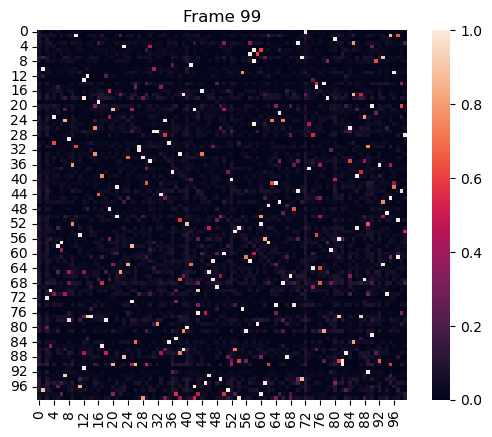

In [17]:
iterations = 100
for i in [100]:
    print(i)
    data = run(100, iterations, runs=1, lrate=i)
plot_heatmap(data, frames=iterations)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def ant_colony_optimization(points, n_ants, n_iterations, alpha, beta, evaporation_rate, Q):
    n_points = len(points)
    pheromone = np.ones((n_points, n_points))
    best_path = None
    best_path_length = np.inf
    
    for iteration in tqdm(range(n_iterations)):
        paths = []
        path_lengths = []
        
        for ant in range(n_ants):
            visited = [False]*n_points
            current_point = np.random.randint(n_points)
            visited[current_point] = True
            path = [current_point]
            path_length = 0
            
            while False in visited:
                unvisited = np.where(np.logical_not(visited))[0]
                probabilities = np.zeros(len(unvisited))
                
                for i, unvisited_point in enumerate(unvisited):
                    probabilities[i] = pheromone[current_point, unvisited_point]**alpha / distance(points[current_point], points[unvisited_point])**beta
                
                probabilities /= np.sum(probabilities)
                
                next_point = np.random.choice(unvisited, p=probabilities)
                path.append(next_point)
                path_length += distance(points[current_point], points[next_point])
                visited[next_point] = True
                current_point = next_point
            
            paths.append(path)
            path_lengths.append(path_length)
            
            if path_length < best_path_length:
                best_path = path
                best_path_length = path_length
        
        pheromone *= evaporation_rate
        
        for path, path_length in zip(paths, path_lengths):
            for i in range(n_points-1):
                pheromone[path[i], path[i+1]] += Q/path_length
            pheromone[path[-1], path[0]] += Q/path_length
    
    # fig = plt.figure(figsize=(8, 6))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(points[:,0], points[:,1], points[:,2], c='r', marker='o')
    
    # for i in range(n_points-1):
    #     ax.plot([points[best_path[i],0], points[best_path[i+1],0]],
    #             [points[best_path[i],1], points[best_path[i+1],1]],
    #             [points[best_path[i],2], points[best_path[i+1],2]],
    #             c='g', linestyle='-', linewidth=2, marker='o')
        
    # ax.plot([points[best_path[0],0], points[best_path[-1],0]],
    #         [points[best_path[0],1], points[best_path[-1],1]],
    #         [points[best_path[0],2], points[best_path[-1],2]],
    #         c='g', linestyle='-', linewidth=2, marker='o')
    
    # ax.set_xlabel('X Label')
    # ax.set_ylabel('Y Label')
    # ax.set_zlabel('Z Label')
    # plt.show()
    return best_path, best_path_length
    
# Example usage:
points = np.random.rand(100, 2) # Generate 10 random 3D points
path, leng = ant_colony_optimization(points, n_ants=10, n_iterations=100, alpha=1, beta=1, evaporation_rate=0.5, Q=1)
print(leng)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.55it/s]

9.744851591153399


In [13]:
import networkx as nx

adj_matrix = np.array([[distance(points[i], points[j]) for j in range(len(points))] for i in range(len(points))])
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
approx = nx.approximation.simulated_annealing_tsp(G, "greedy", source=0)

running_total = 0
for i in range(len(approx)-1):
    running_total += (distance(points[approx[i] % len(points)], points[approx[i+1] % len(points)]))
running_total

9.417802257180748

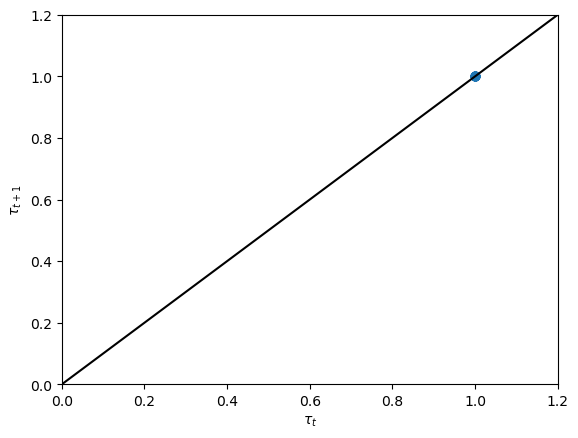

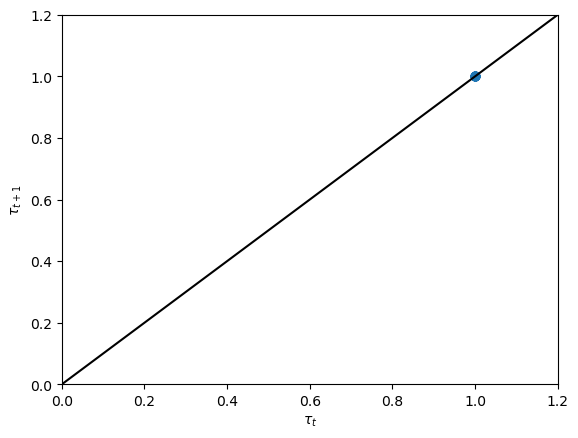

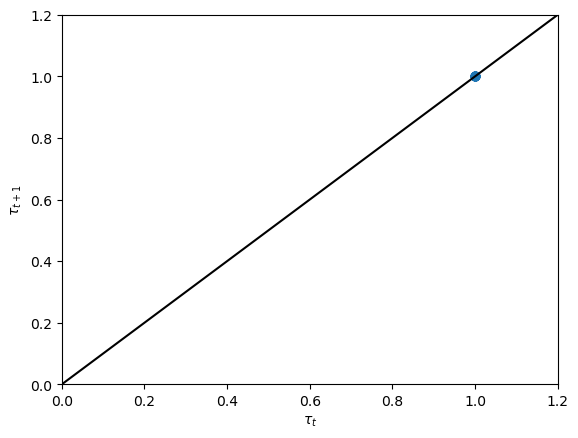

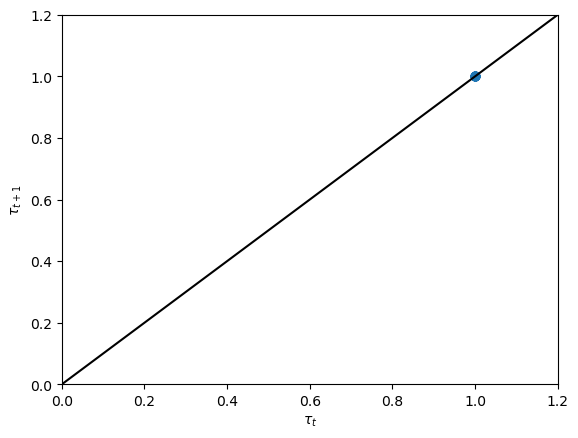

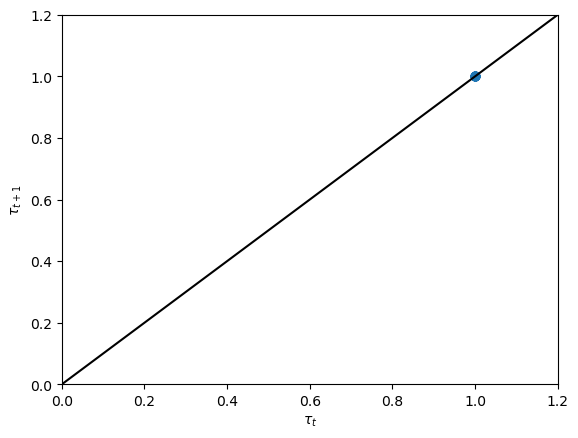

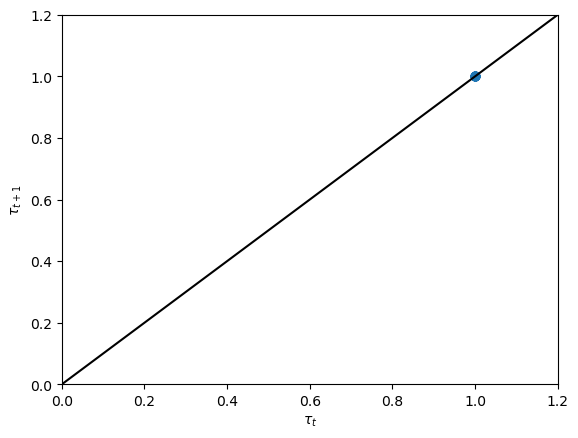

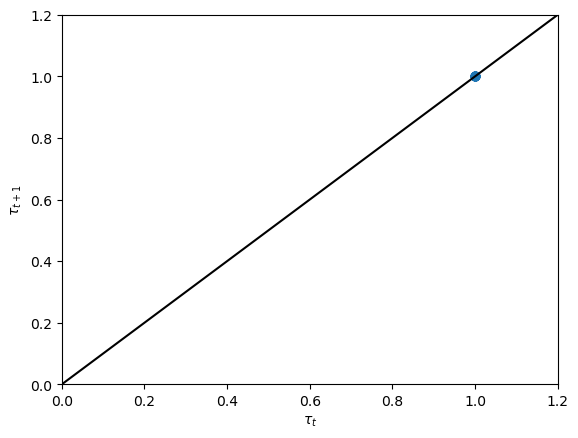

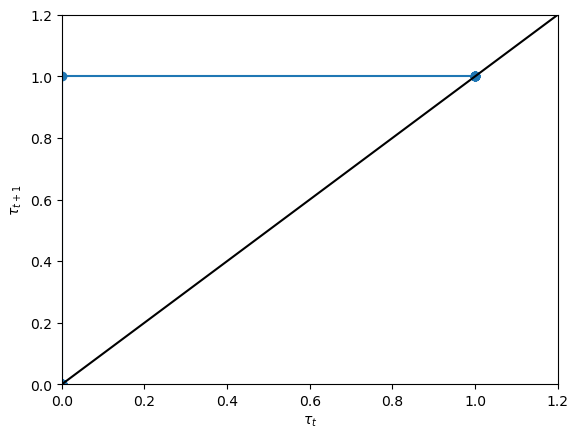

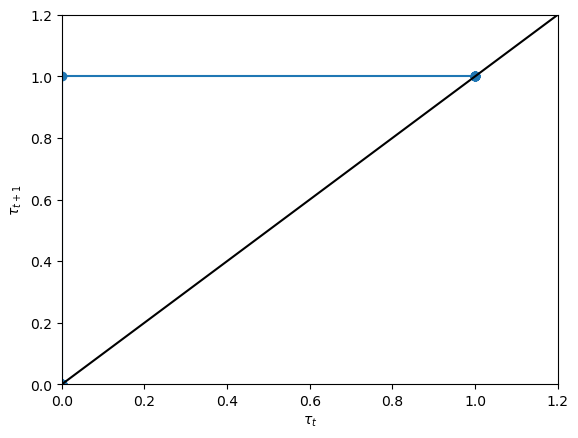

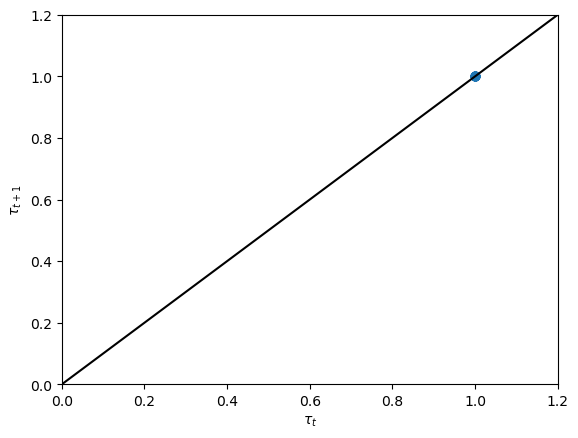

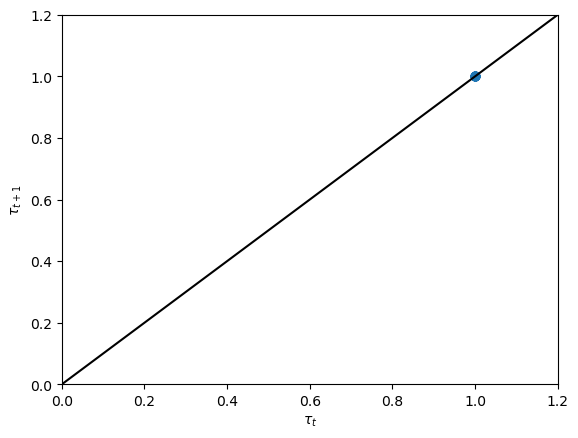

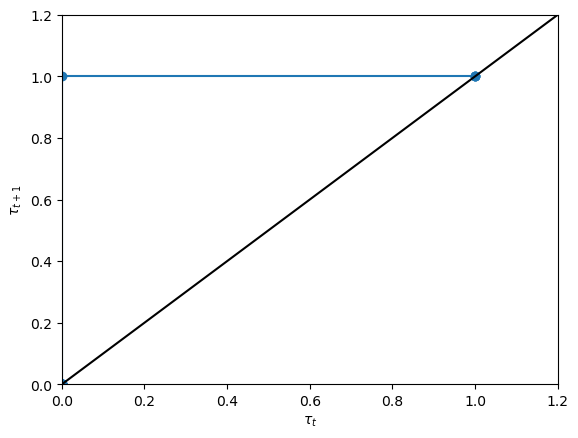

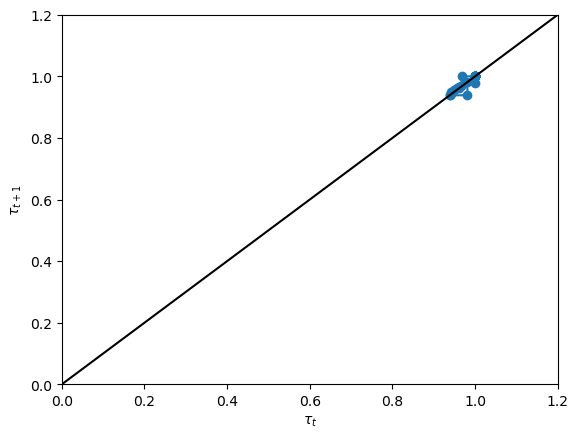

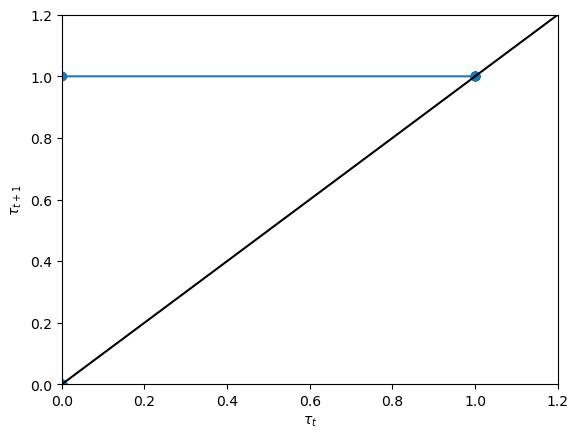

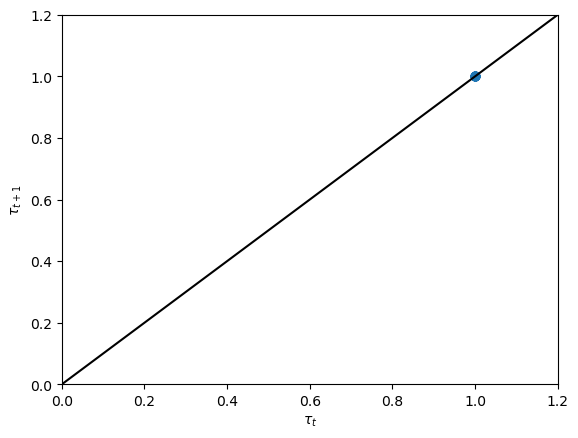

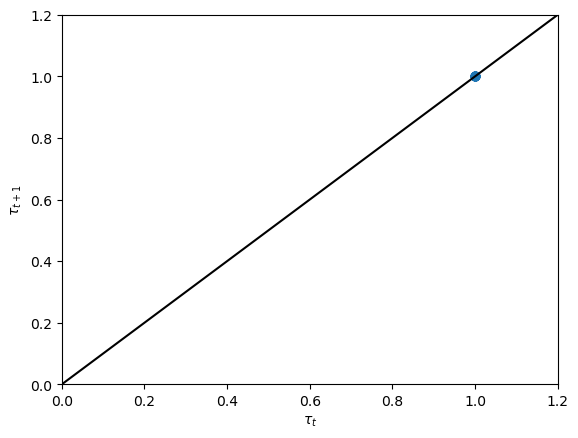

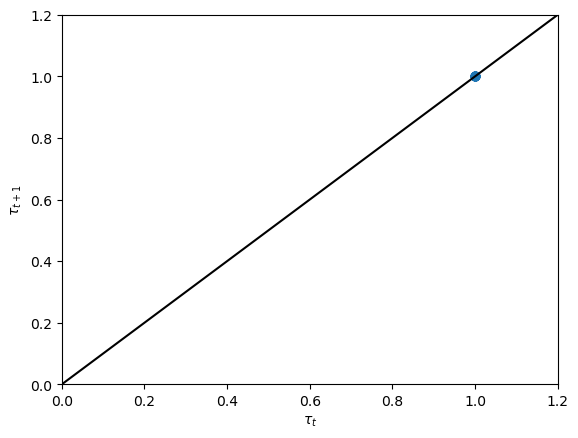

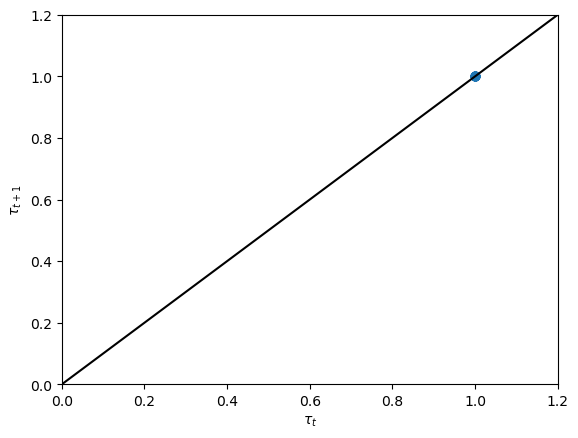

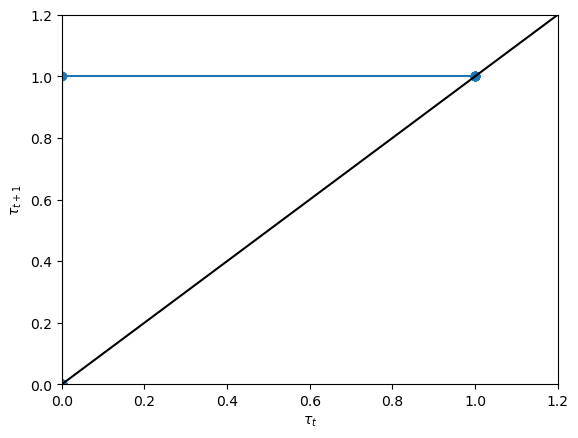

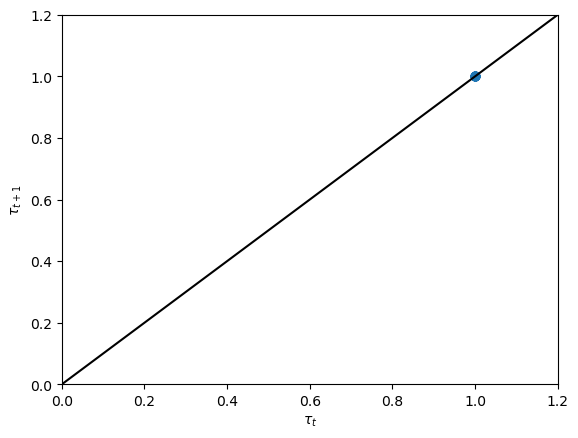

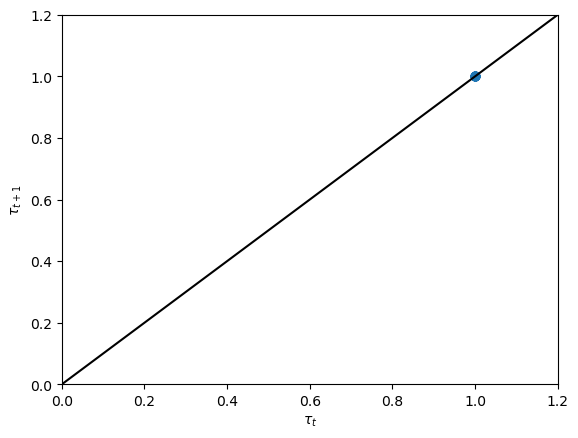

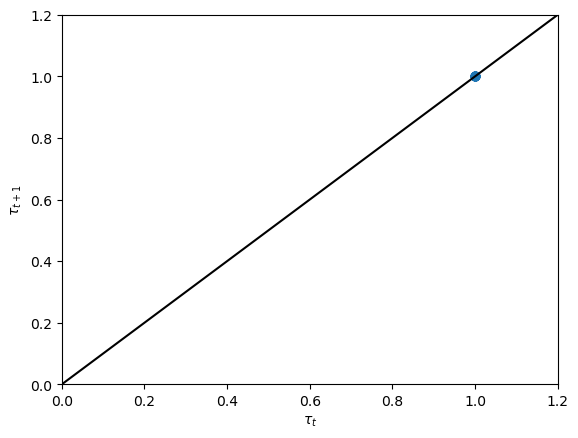

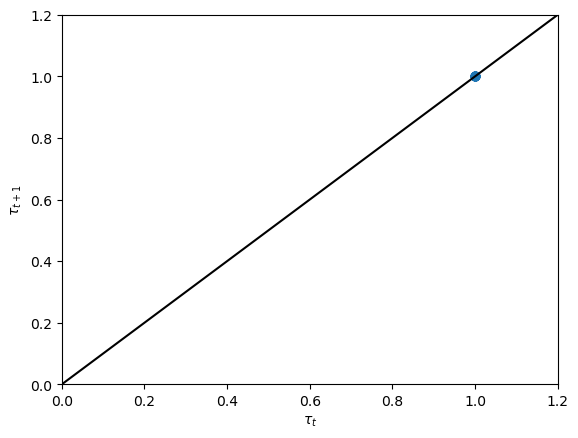

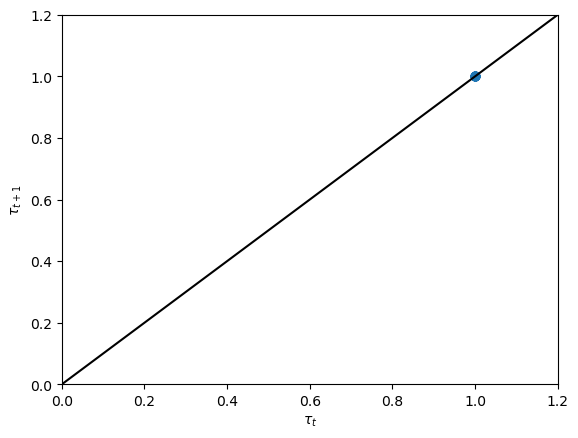

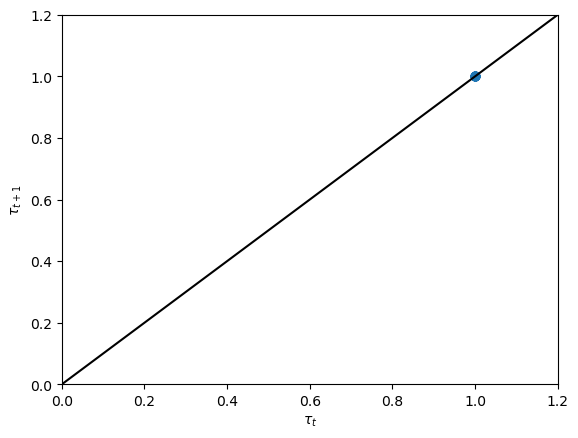

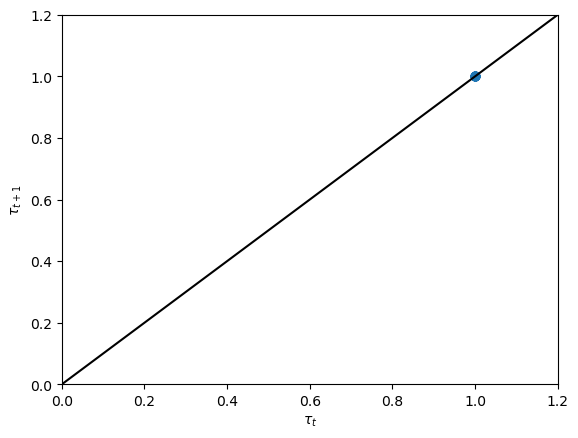

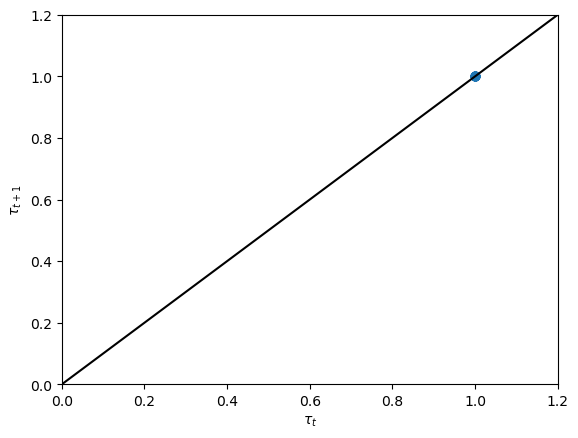

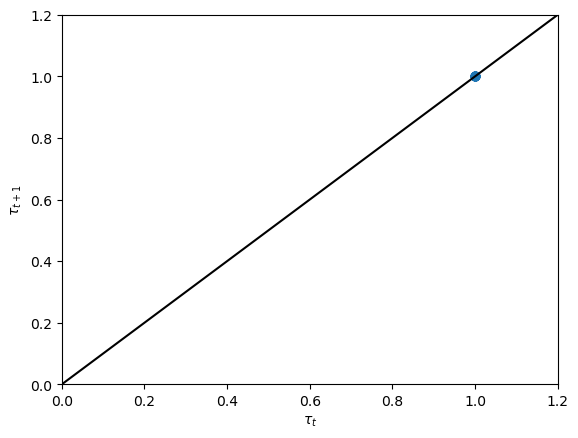

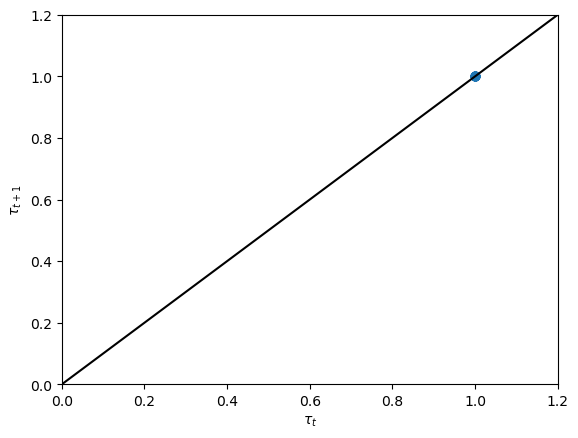

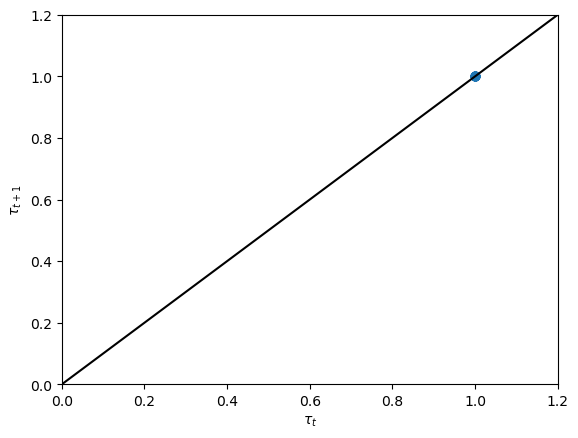

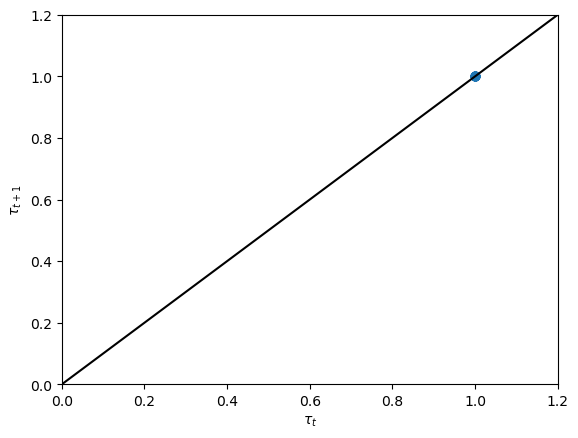

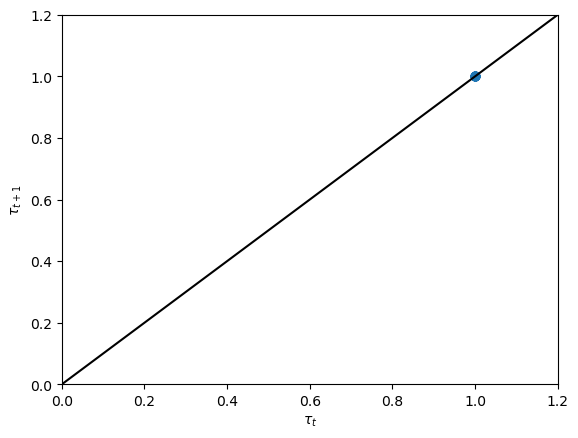

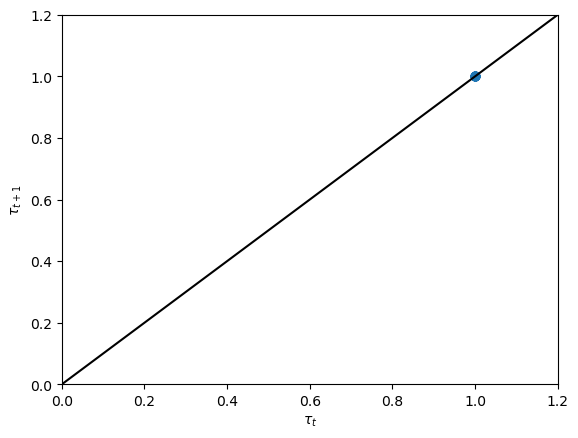

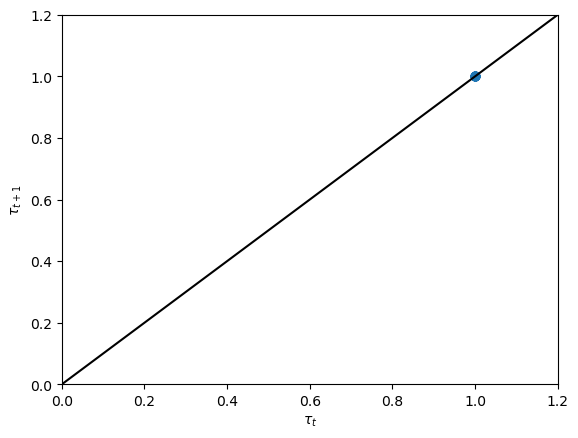

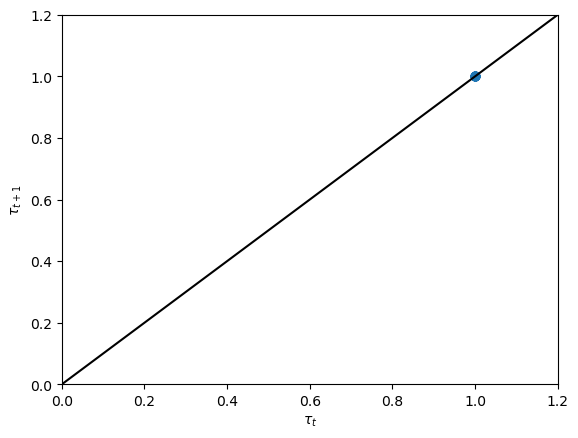

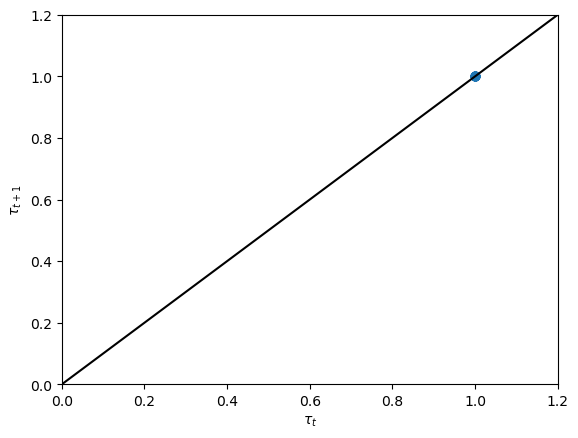

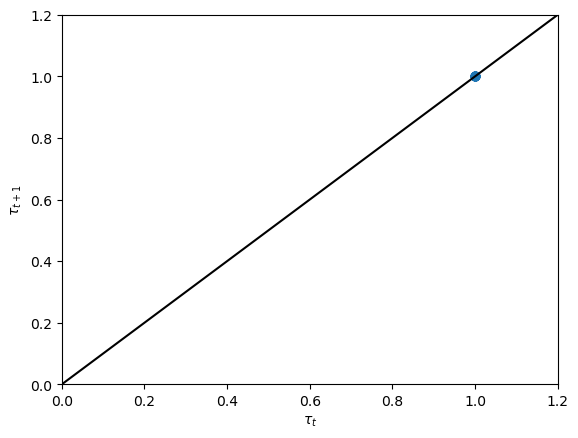

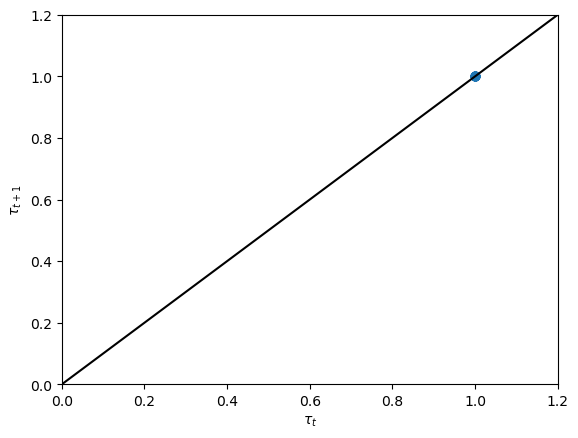

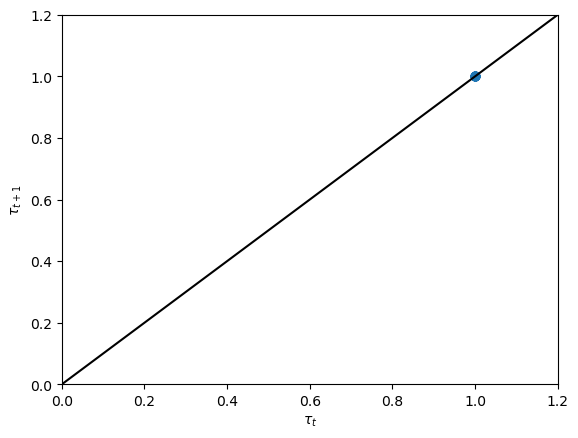

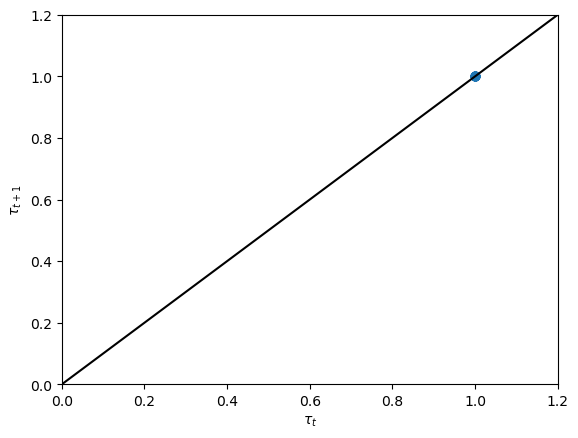

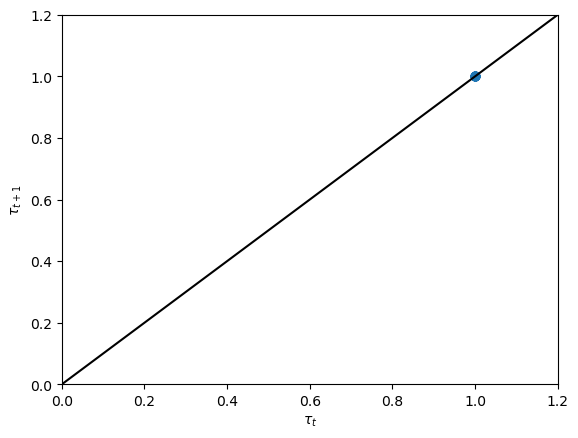

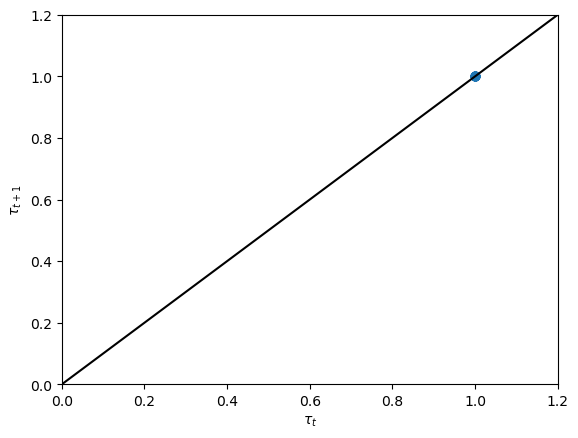

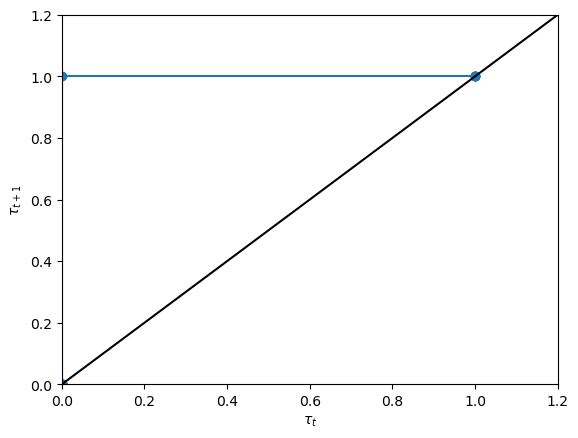

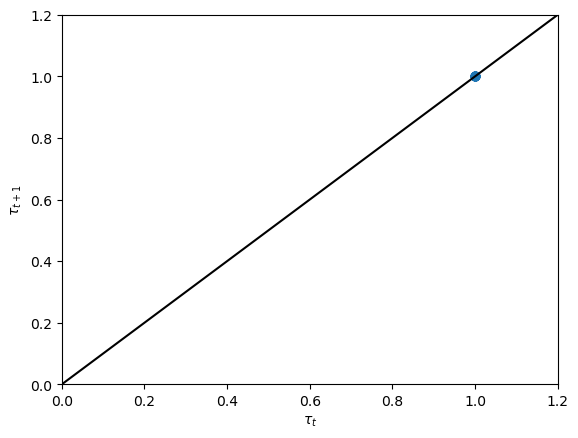

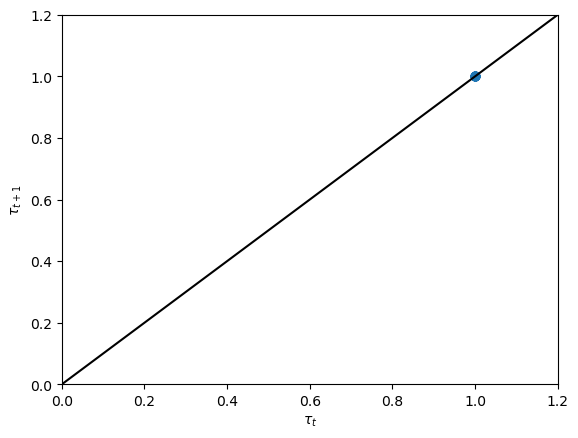

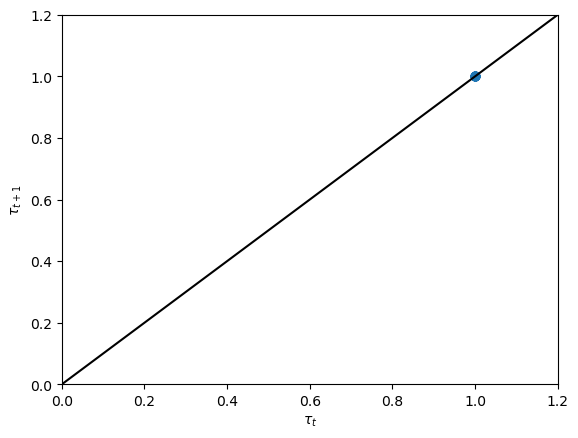

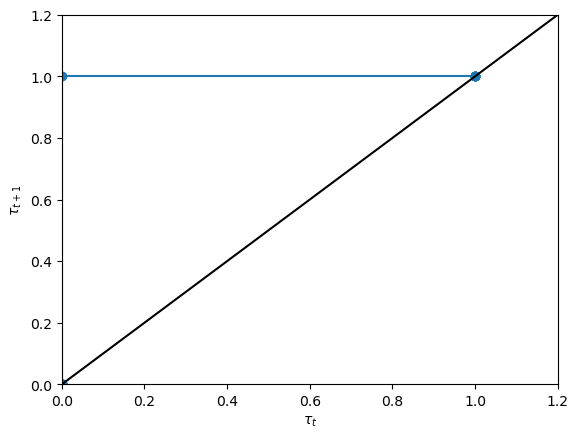

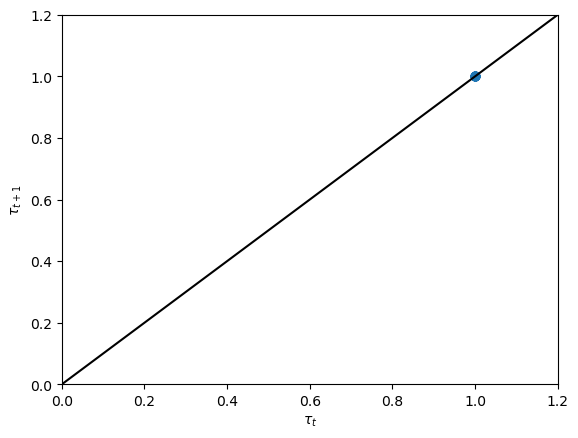

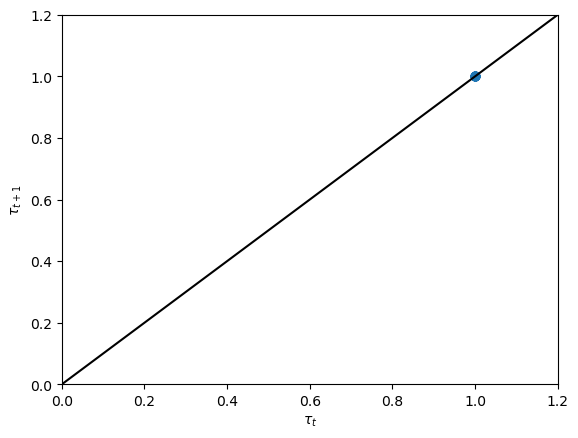

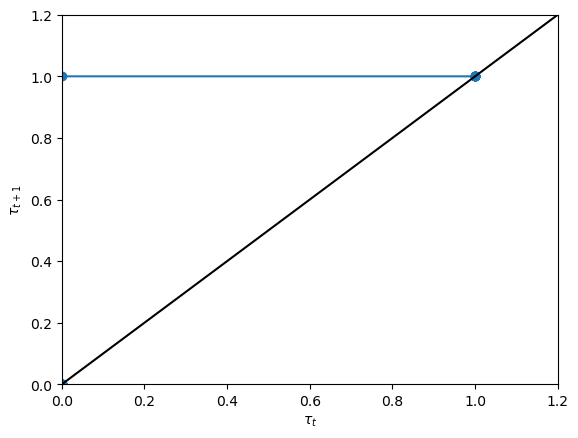

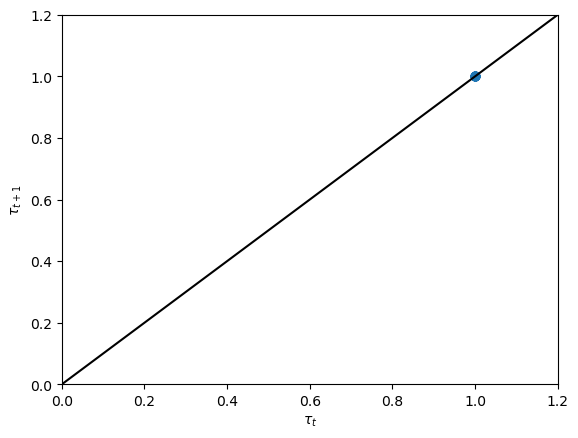

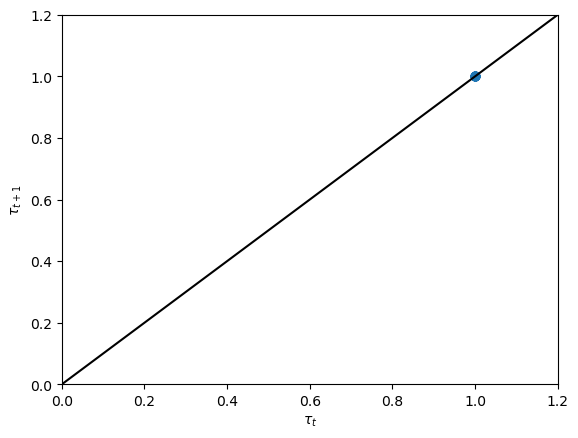

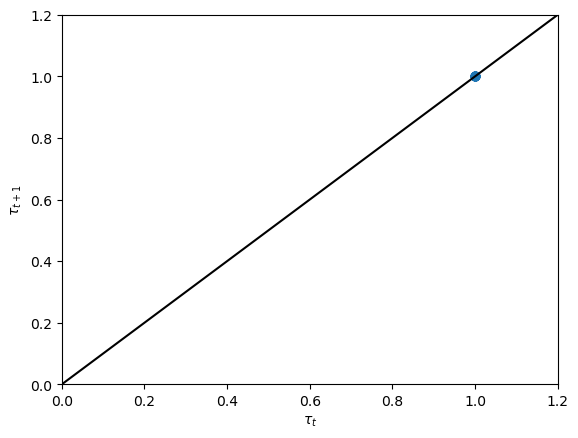

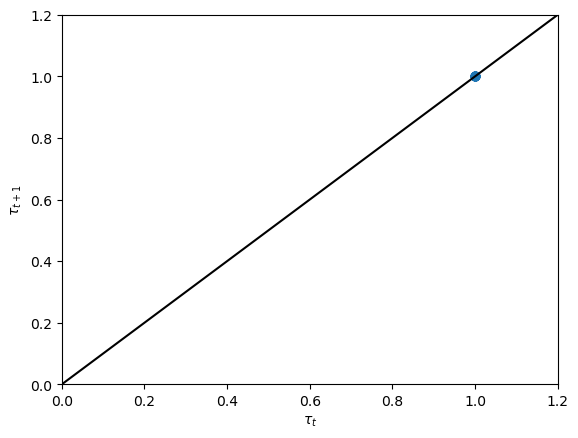

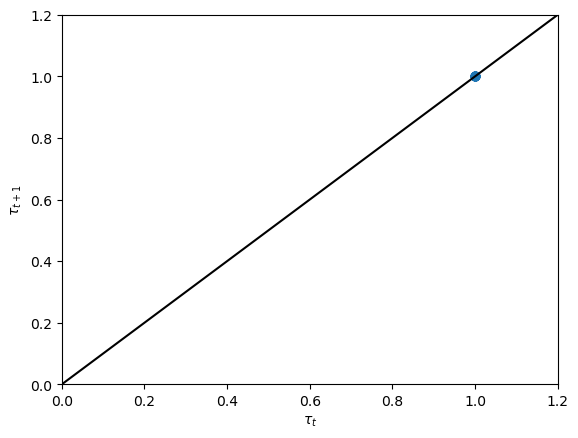

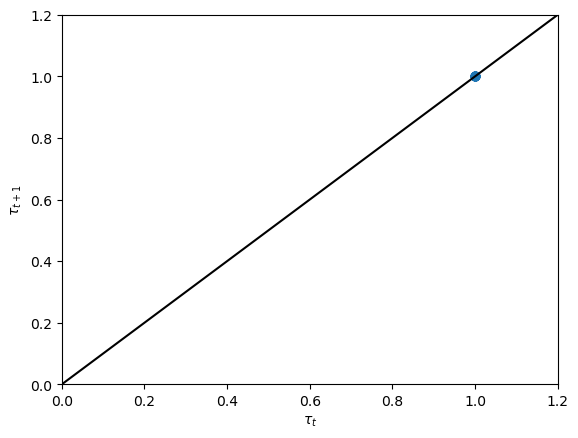

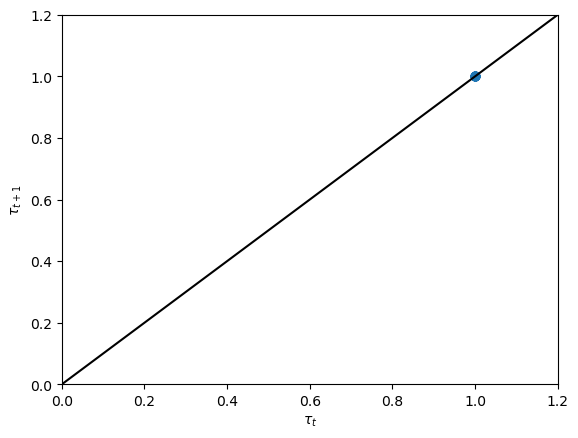

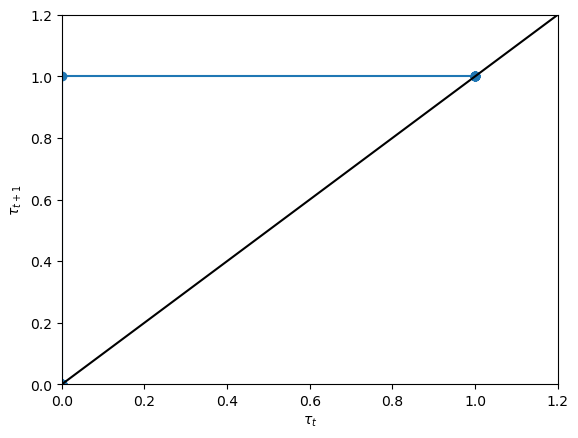

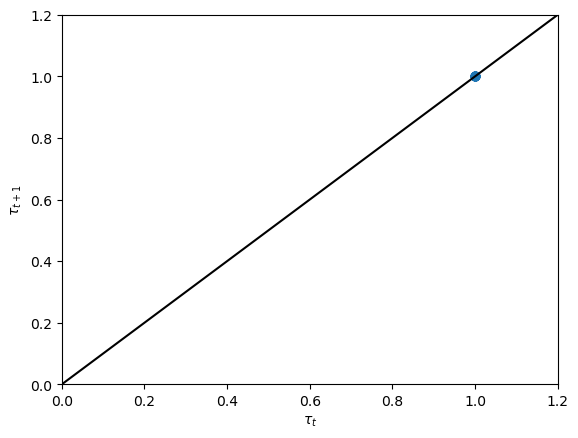

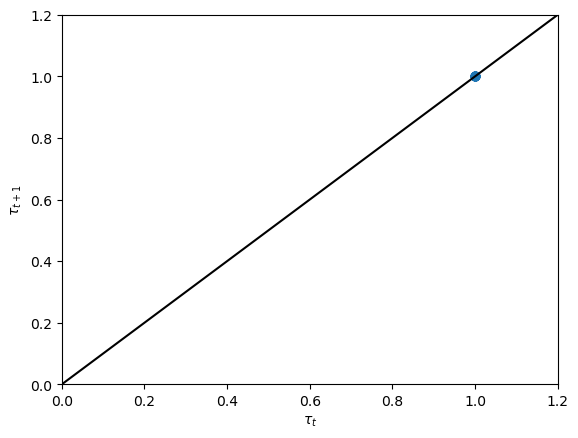

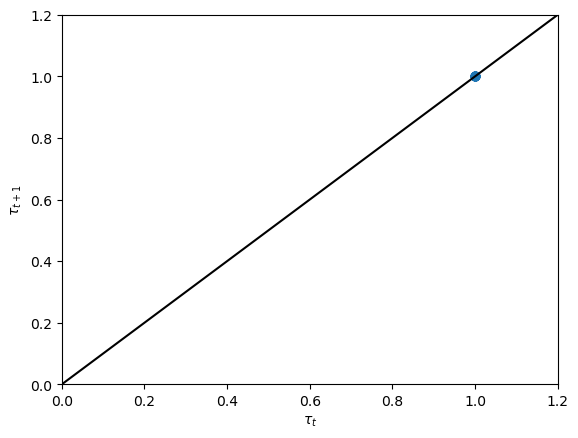

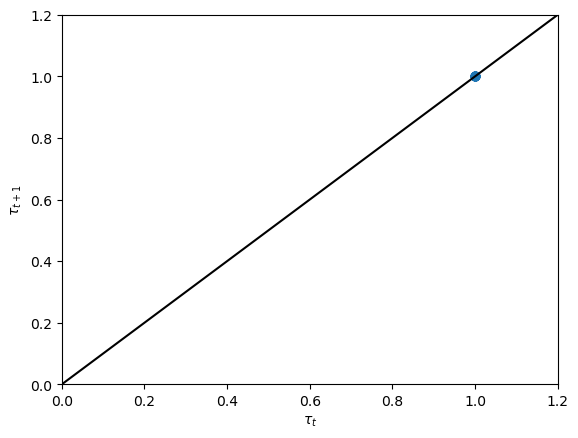

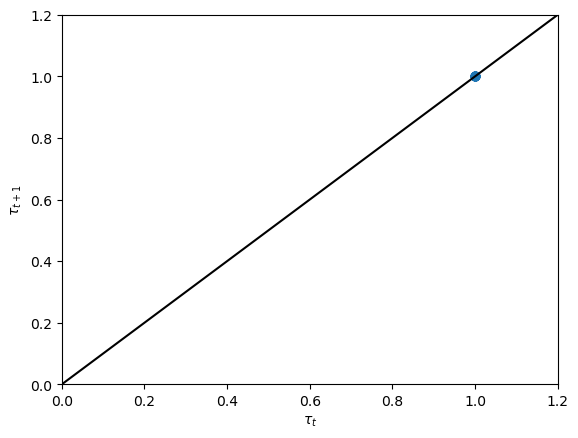

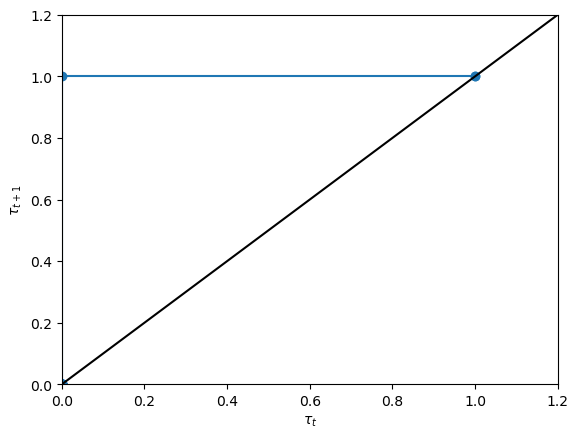

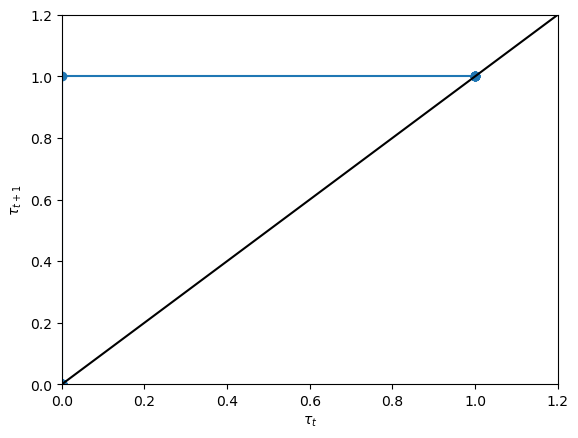

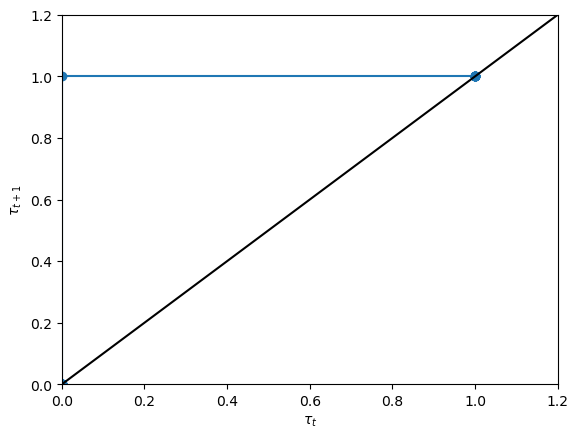

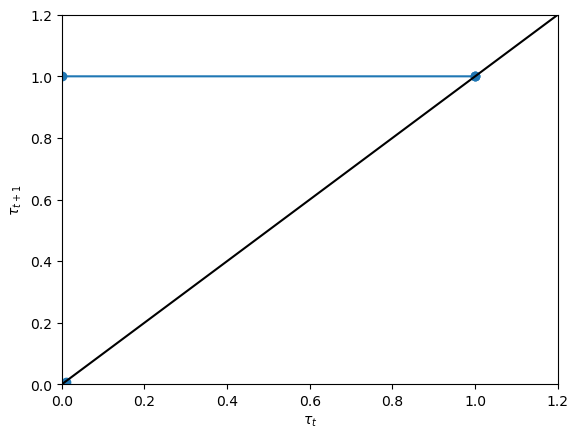

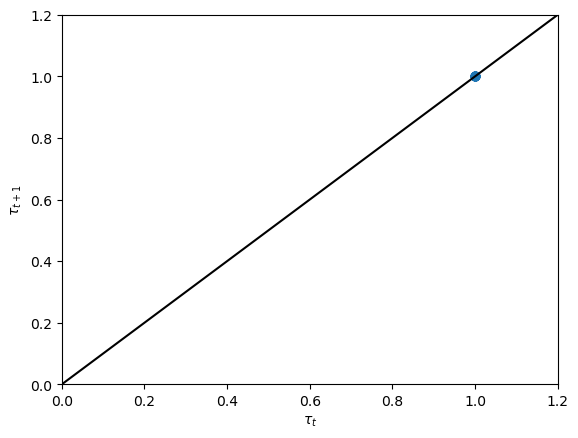

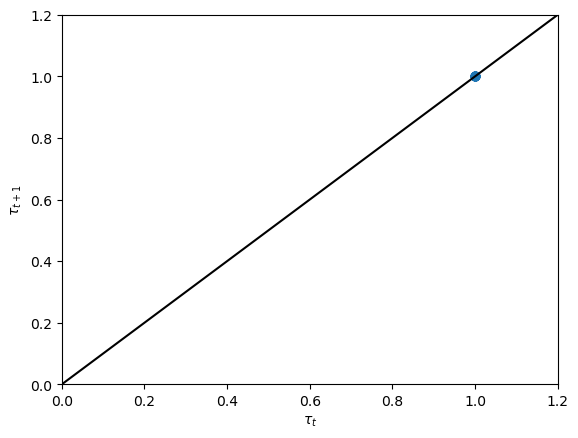

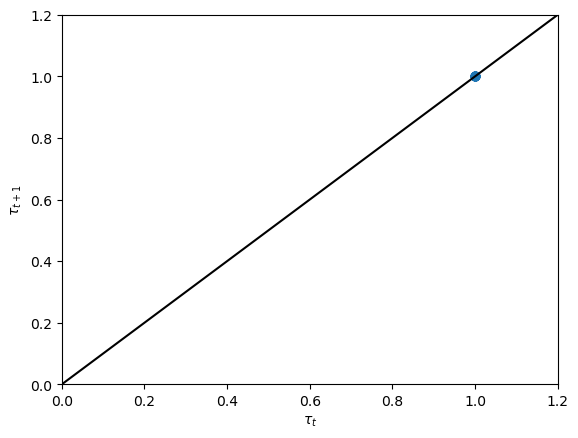

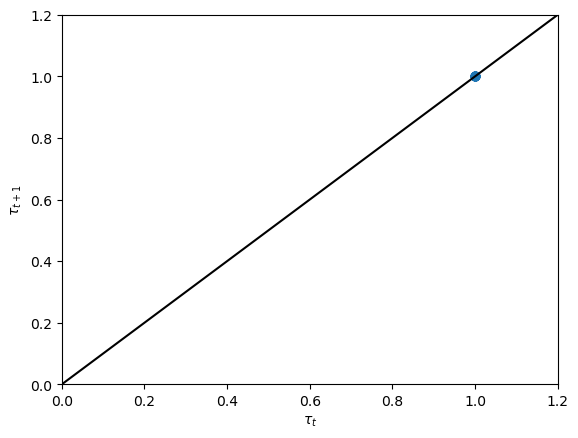

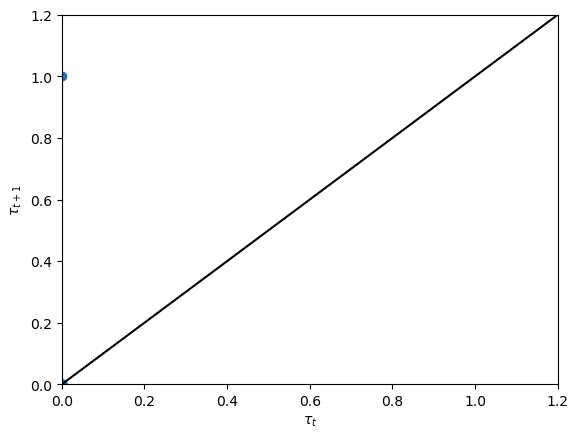

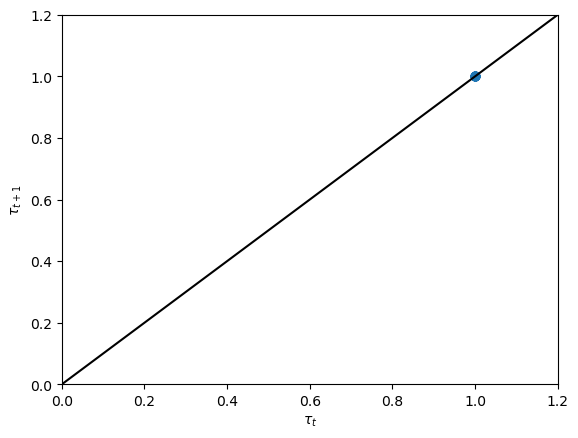

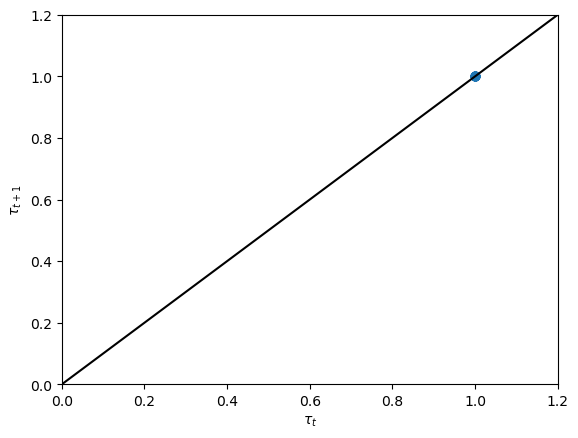

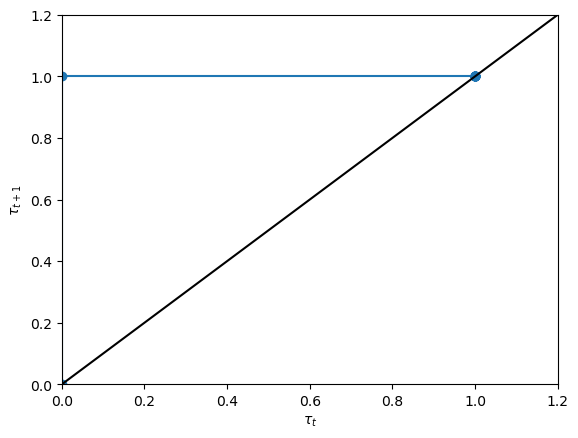

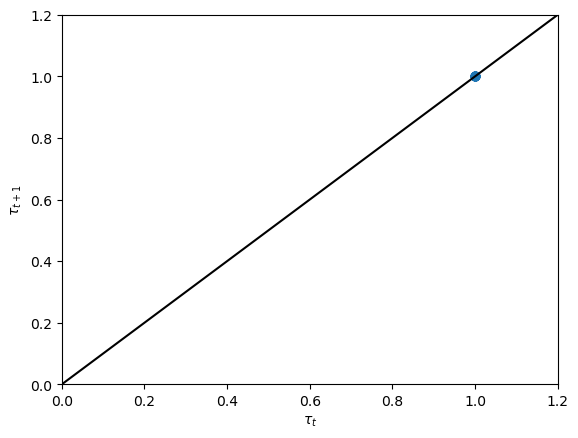

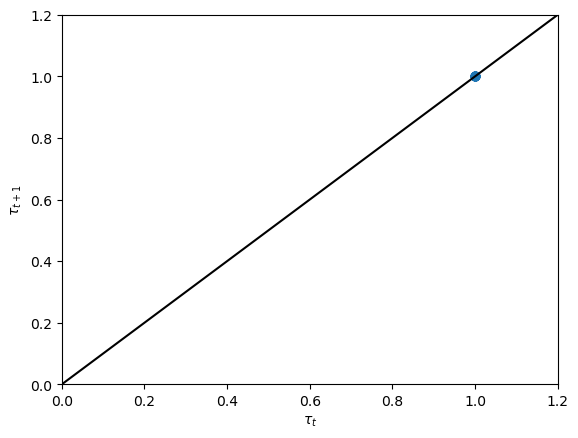

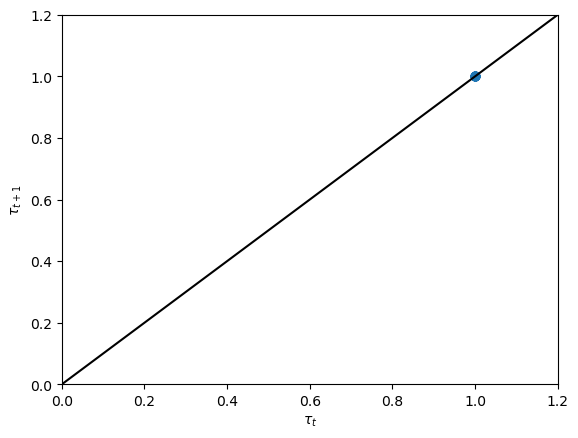

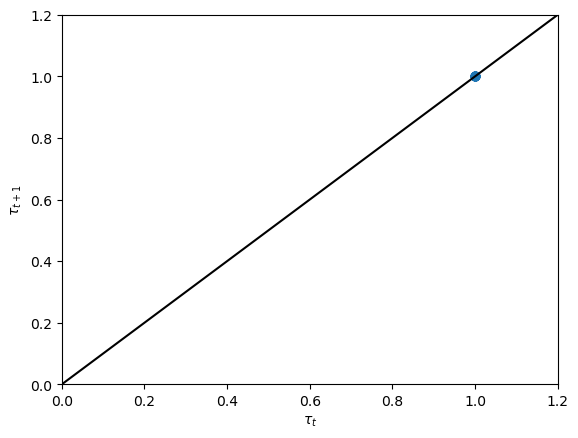

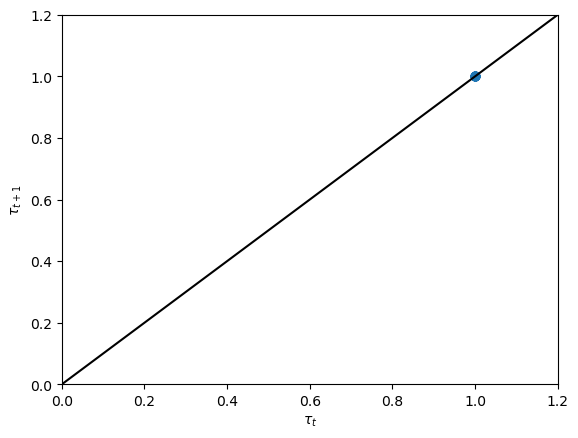

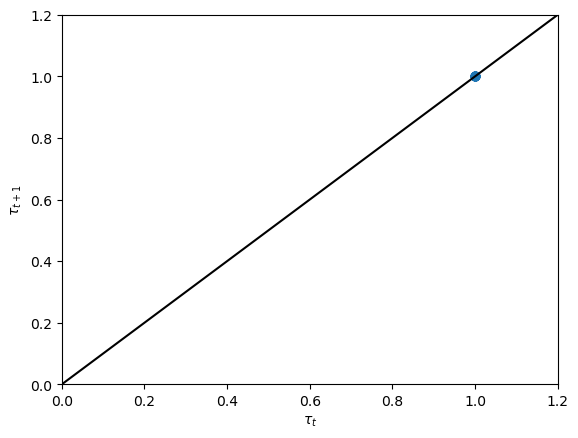

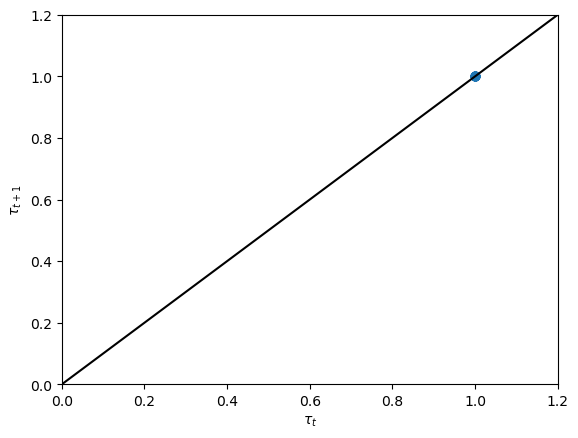

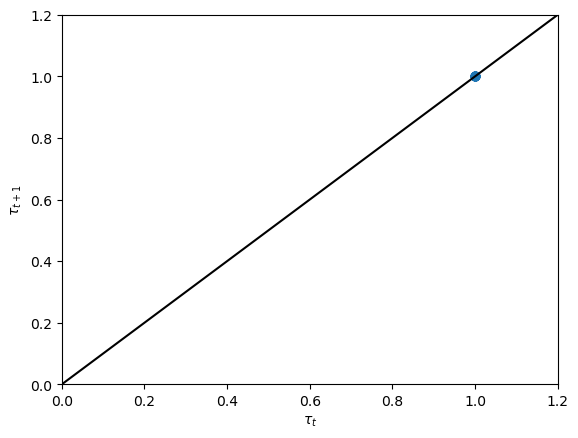

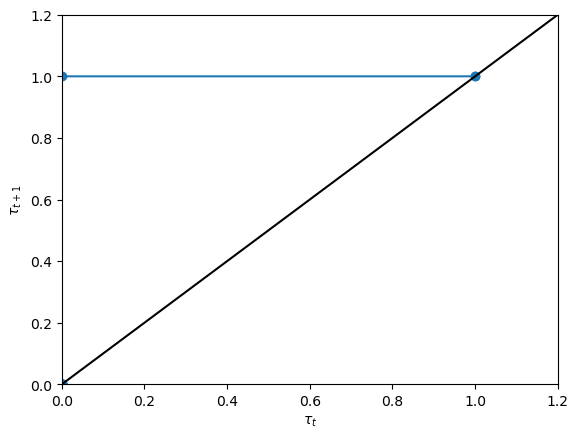

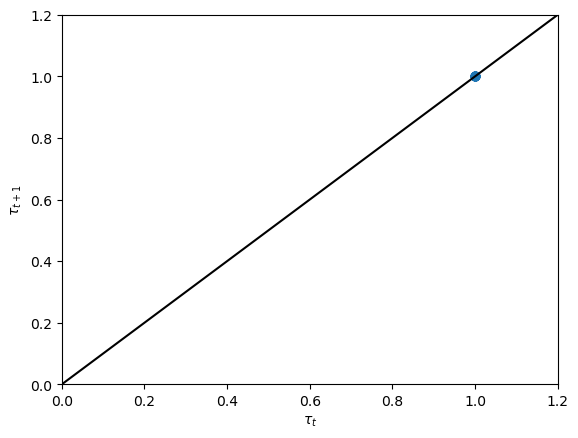

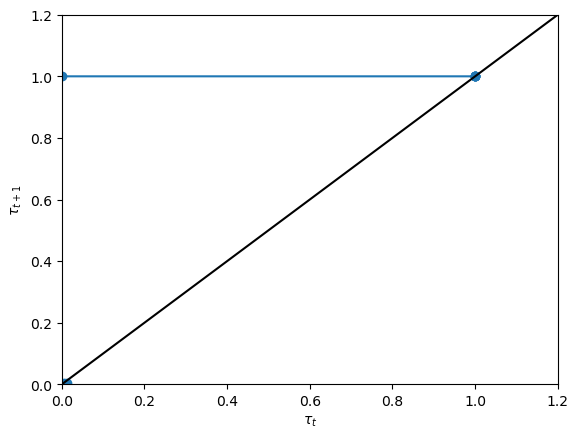

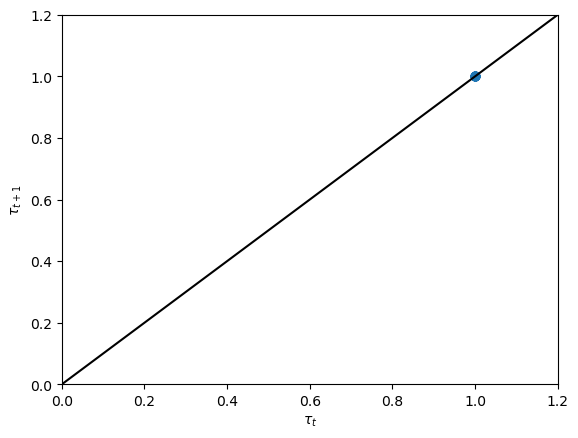

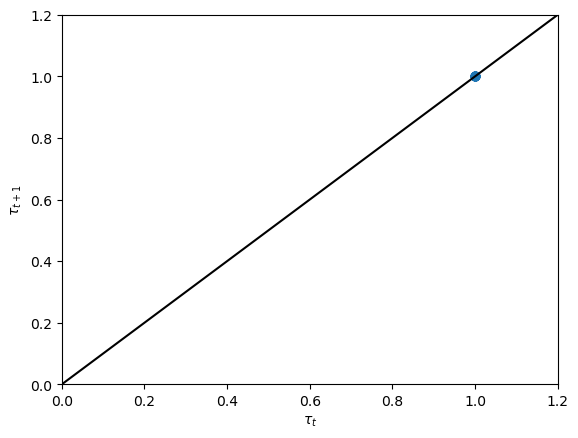

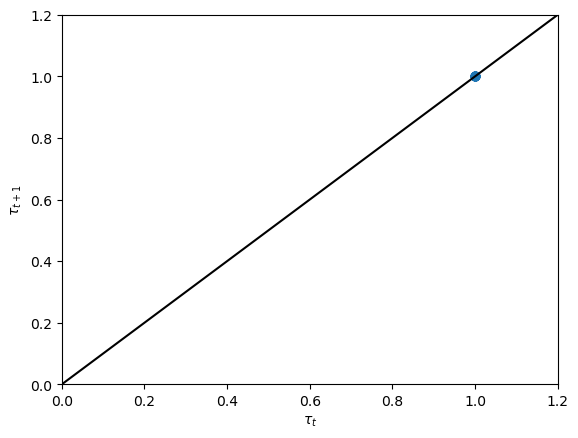

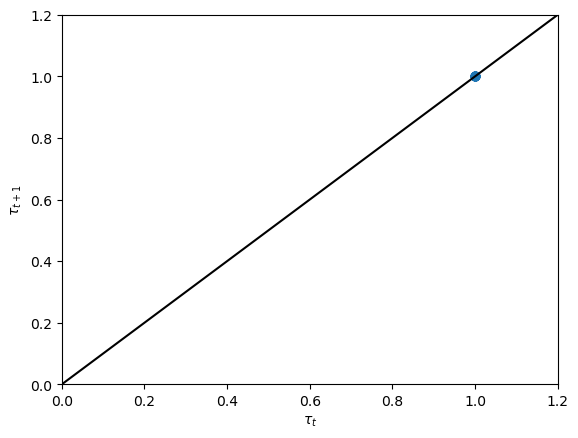

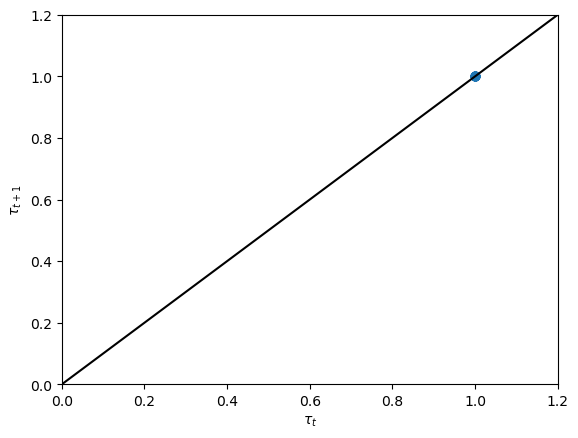

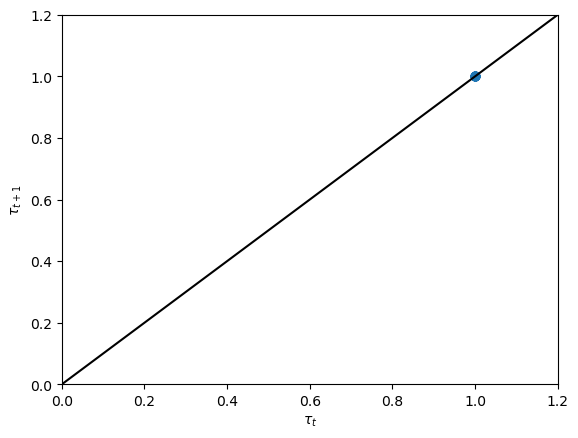

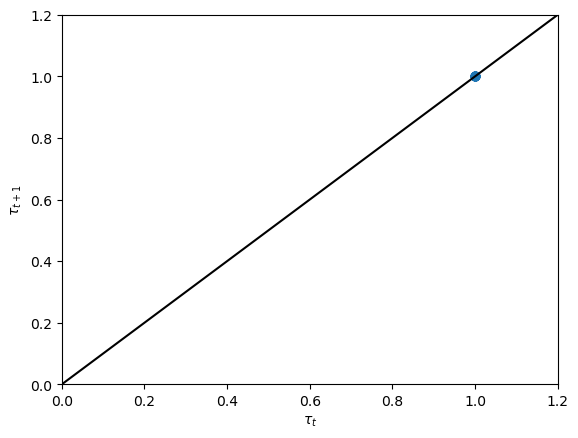

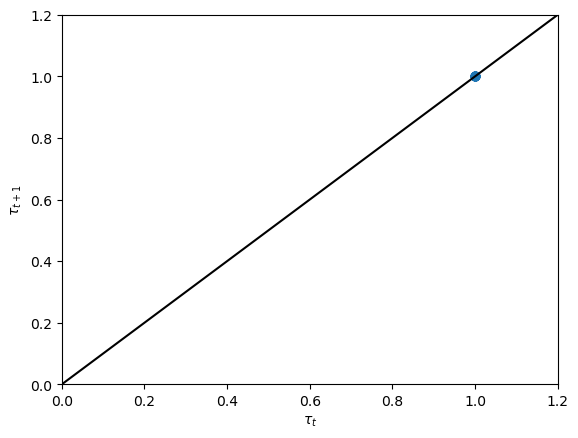

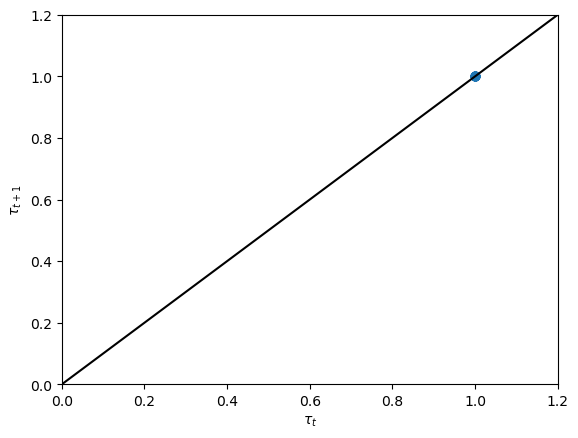

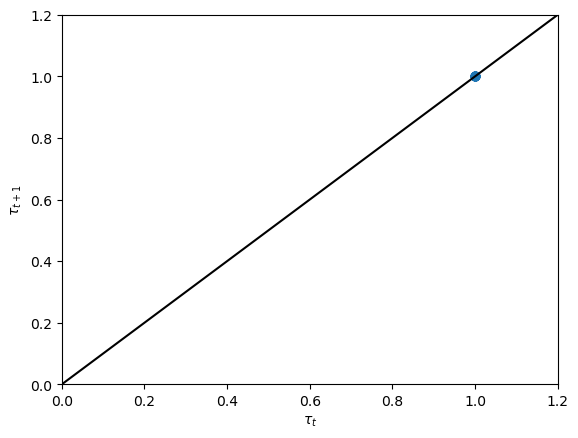

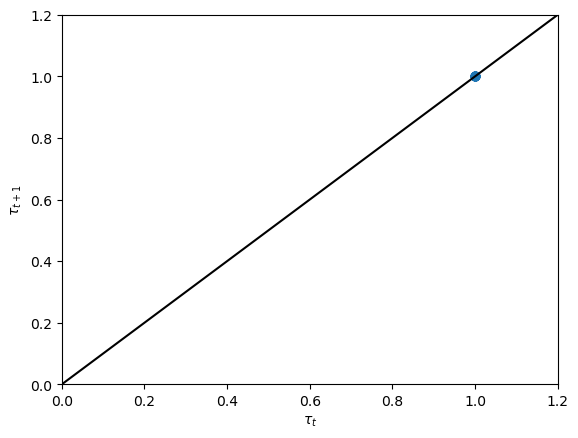

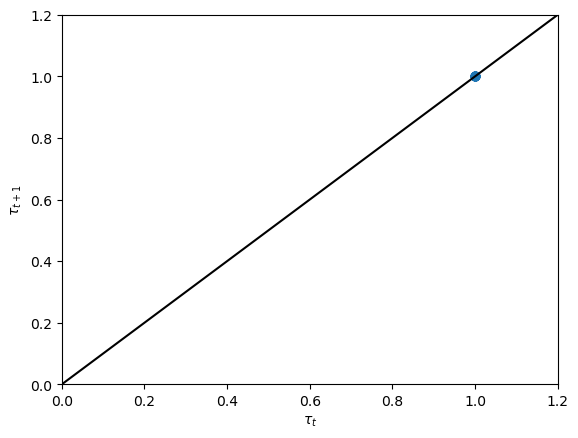

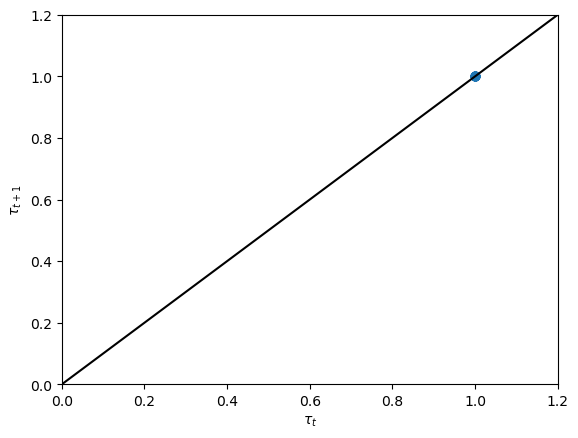

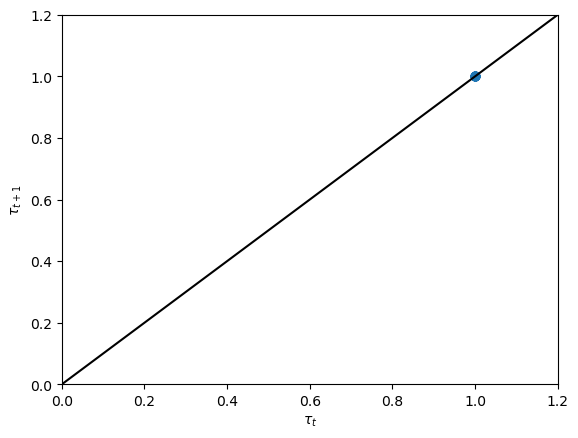

In [14]:
traces = data[:, *np.where(data[-1, :, :] == 1)].T

start = 70
for i in traces:
    plt.scatter(i[start:-1], i[start+1:])
    plt.plot(i[start:-1], i[start+1:])
    plt.xlim(0, 1.2)
    plt.xlabel(r'$\tau_t$')
    plt.ylim(0, 1.2)
    plt.ylabel(r'$\tau_{t+1}$')
    plt.plot([0, 1.2], [0, 1.2], c="black")
    plt.show()

In [15]:
np.where(data[-1, :, :] == 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([84, 70, 99, 21, 48, 91,  9, 67, 22, 69, 85, 38,  6, 21, 52, 88, 29,
        39, 14,  4, 67, 83, 41, 92, 65, 36, 96, 53, 33, 12, 81, 20, 34, 68,
        58,  5, 92, 56, 11, 90, 57, 26, 21, 82, 12, 63, 72, 32, 30, 48, 40,
        43, 94, 16, 45, 53, 69, 14, 74, 99, 25, 37, 70, 10, 73, 21, 47, 95,
        45, 78, 64, 78, 34, 67, 59, 56, 87, 93, 29, 75, 40, 97, 44, 36, 17,
        20, 18, 79,  2, 20, 54,  1, 60, 23, 51, 18, 32, 76, 52, 61]))

In [16]:
data[-1, :, :]

array([[1.37105699e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.35646427e-04, 2.35646427e-04, 2.07885398e-04, ...,
        0.00000000e+00, 5.31206184e-01, 4.90606449e-05],
       [3.58981886e-04, 0.00000000e+00, 3.58981886e-04, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [1.96434043e-05, 0.00000000e+00, 6.53964184e-04, ...,
        1.96434043e-05, 0.00000000e+00, 0.00000000e+00],
       [1.05966717e-04, 0.00000000e+00, 7.45719037e-06, ...,
        0.00000000e+00, 1.05966717e-04, 0.00000000e+00],
       [1.64798046e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.78903005e-03, 1.64798046e-03]])